We start by importing the streets data and gdf.

- Segment streets into pieces
- Get grade of each piece
- Draw perpendiculars from each endpoint to find sidewalk (say w/i 1.2 meters)
- Cut sidewalk at those points
-    find segment
-    split in two (look at rounding.ipynb)
-    be sure to add *unique* ids
-    DO NOT REMOVE ANYTHING, just add "grade" column


In [2]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point, LineString, MultiLineString
scipy.ndimage

In [3]:
# the node names here are irrelevant
brighton_streets = gpd.read_file("../../data/brighton/brighton_streets.shp").to_crs("EPSG:26919")
brighton_sidewalks = gpd.read_file("../../data/brighton/brighton_sidewalks_diditwork.shp")

crs_global = "EPSG:4326"
crs_local = "EPSG:26919"

In [4]:
def round_pt(pt):
    a, b = pt
    a = round(a,1)
    b = round(b,1)
    return Point(a,b)

def round_edge(edge):
    if type(edge) == MultiLineString:
        edges = edge.geoms
        return MultiLineString(list(map(round_edge, edges)))
    else:
        return LineString(map(round_pt, list(edge.coords)))

brighton_streets.geometry = brighton_streets.geometry.map(round_edge)

In [5]:
brighton_streets.drop(inplace=True, columns=['key','name','highway','sw_left','sw_right'])


In [6]:
from shapely.ops import linemerge

def safe_linemerge(line):
    if type(line) == MultiLineString:
        return linemerge(line.geoms)
    else:
        return line

def safe_pre_explode(line):
    if type(line) == MultiLineString:
        return line.geoms
    else:
        return line
    
def safe_explode(gdf):
    rows = []
    old_rows =[]
    for i, row in gdf.iterrows():
        if type(row['geometry']) == MultiLineString:
            mline = row.geometry
            for line in mline:
                new_row = row
                new_row.geometry = line
                rows.append(new_row)
                old_rows.append(i)
            
    new_gdf = gpd.GeoDataFrame(rows)
    new_gdf.crs = "EPSG:26919"
    gdf = gdf.drop(old_rows)
    gdf = gdf.append(new_gdf)
    return gdf
 

In [7]:
brighton_streets = safe_explode(brighton_streets).reset_index(drop=True)

In [8]:
# Thank you Sean Gilles https://gist.github.com/sgillies/465156#file_cut.py
from shapely.geometry import LineString, Point
from copy import deepcopy
def cut(line, distance):
    # Cuts a line in two at a distance from its starting point
    if distance <= 0.0 or distance >= line.length:
        return [LineString(line)]
    coords = list(line.coords)
    for i, p in enumerate(coords):
        pd = line.project(Point(p))
        if pd == distance:
            return [
                LineString(coords[:i+1]),
                LineString(coords[i:])]
        if pd > distance:
            cp = line.interpolate(distance)
            return [
                LineString(coords[:i] + [(cp.x, cp.y)]),
                LineString([(cp.x, cp.y)] + coords[i:])]
        

# here's me
def recursive_cut(line, distance):
    if [line] == cut(line, distance):
        return [line]
    else:
        segment, rest = cut(line, distance)
        return [segment] + recursive_cut(rest, distance)
    
           
def list_explode(gdf):
    rows = []
    old_rows = []
    for i, row in gdf.iterrows():
        mline = row['cut_geometry']
        new_rows = [deepcopy(row) for i in range(len(row['cut_geometry']))]
        for n, inline in enumerate(mline):
            new_rows[n]['geometry'] = inline
            old_rows.append(i)
        rows.extend(new_rows)
    new_gdf = gpd.GeoDataFrame(rows).reset_index(drop=True)
    new_gdf.crs = "EPSG:26919"
    return new_gdf


In [9]:
CUT_LENGTH = 4
brighton_streets['cut_geometry'] = brighton_streets.geometry.map(lambda x : recursive_cut(x, CUT_LENGTH))
# brighton_streets.cut_geometry.map(len).sum() == 41900
# len(list_explode(brighton_streets))



In [10]:
brighton_streets = list_explode(brighton_streets).drop(columns=['cut_geometry','u','v','length'])

In [11]:
brighton_streets.geometry = brighton_streets.geometry.map(round_edge)

In [12]:
brighton_streets = brighton_streets.to_crs("EPSG:4326")

In [13]:
brighton_streets['p0'] = brighton_streets.geometry.map(lambda x : x.coords[0])
brighton_streets['p1'] = brighton_streets.geometry.map(lambda x : x.coords[1])

In [14]:
import numpy as np
len(brighton_streets[brighton_streets.length > 0.00004]), len(brighton_streets)
#len(set(np.concatenate(brighton_streets[['p0','p1']].values)))

(33373, 52090)

In [15]:
def linestring_heading(linestring):
    # 0 is north, 90 is east
    # so heading = 90 - usual_angle (in standard form)
    
    # usual points are in long/lat
    
    (l1,l2) = linestring_start(linestring)
    (m1,m2) = linestring_end(linestring)
    angle_deg = math.atan2(m2-l2, m1-l1) * 360 / (2 * math.pi)
    heading_deg = int((90 - angle_deg) % 360)
    return(heading_deg)

In [9]:
import rasterio
dataset = rasterio.open("../../data/brighton/elevation.tif")

In [10]:
dataset.crs, dataset.bounds #hell yeah

(CRS.from_epsg(4326),
 BoundingBox(left=-72.00013888888888, bottom=41.99986111111111, right=-70.9998611111111, top=43.000138888888884))

In [11]:
# get the first "band"
# this is a numpy array
# now dataset.index(lat, lon) gives the array index for that point
band1 = dataset.read(1)


In [14]:
brighton_sidewalks['cut_geometry'] = brighton_sidewalks.geometry.map(lambda x : recursive_cut(x, 4))
brighton_sidewalks = list_explode(brighton_sidewalks)

brigthon_sidewalks = brighton_sidewalks.to_crs("EPSG:4326")

In [19]:
brighton_streets['elevation_0'] = brighton_streets.geometry.map(lambda x : band1[dataset.index(x.coords[0][0], x.coords[0][1])])
brighton_streets['elevation_1'] = brighton_streets.geometry.map(lambda x : band1[dataset.index(x.coords[1][0], x.coords[1][1])])

In [20]:
brighton_streets = brighton_streets.to_crs("EPSG:26919")
brighton_streets['length_m'] = brighton_streets.length

In [21]:
def slope(row):
    rise = row['elevation_1'] - row['elevation_0']
    run = row['length_m']
    return rise/run

brighton_streets_long = brighton_streets[brighton_streets['length_m'] > 1].copy(deep=True)
brighton_streets_long['slope'] = brighton_streets_long.apply(slope, axis=1)

In [22]:
import math
brighton_streets_long['angle_deg'] = brighton_streets_long['slope'].map(lambda x : math.atan(x) * 360 / ( 2 * math.pi))

In [23]:
# resolution is really bad
# the minimum non-zero rise is 1
# the run is 4
# so the minimum non-zero angle is +-14 degrees!
# math.atan(1/4) * 360 / (2 * math.pi)
bad_segs = brighton_streets_long[(brighton_streets_long['angle_deg'] > 5) | (brighton_streets_long['angle_deg'] < -5)]

In [24]:
len(bad_segs)/len(brighton_streets_long), bad_segs.length.sum()/brighton_streets_long.length.sum()

(0.12298957485563694, 0.12359988868900382)

In [25]:
# next steps:
# given the left and right sides: find the nearest nodes (within some distance?)
# find the shortest path between them (using only sidewalks? and also of capped distance?)
# delete all those nodes!

# first need to segment sidewalks

In [27]:
brighton_sidewalks['cut_geometry'] = brighton_sidewalks.geometry.map(lambda x : recursive_cut(x, 4))
brighton_sidewalks = list_explode(brighton_sidewalks)


In [28]:
brighton_sidewalks['length'] = brighton_sidewalks.length
brighton_sidewalks.drop(inplace=True, columns=['cut_geometry'])

In [29]:
brighton_sidewalks.geometry = brighton_sidewalks.geometry.map(round_edge)

In [30]:
# setup routing
import osmnx as ox 
points = list(map(Point, (list(set([point for ls in list(brighton_sidewalks.geometry.map(lambda x : list(x.coords)).values) for point in ls])))))
brighton_sw_points = gpd.GeoDataFrame(points)
brighton_sw_points.geometry = brighton_sw_points[0]
len_sw = len(list(brighton_sw_points.geometry.map(lambda x : x.coords)))
sw_coord_dict = dict(list(set(zip(list(brighton_sw_points.geometry.map(lambda x : tuple(x.coords)[0])), range(len_sw)))))

sw_coords = sw_coord_dict.keys()

from shapely.coords import CoordinateSequence
brighton_sidewalks['u'] = brighton_sidewalks.geometry.map(lambda x : sw_coord_dict[x.coords[0]])
brighton_sidewalks['v'] = brighton_sidewalks.geometry.map(lambda x : sw_coord_dict[x.coords[-1]])
brighton_sidewalks['key'] = 0
brighton_sidewalks['osmid'] = brighton_sidewalks.index.map(lambda x : 1000000000 * x)

brighton_sw_points['id'] = brighton_sw_points.geometry.map(lambda x : sw_coord_dict[x.coords[0]])
brighton_sw_points['osmid'] = brighton_sw_points.id

brighton_sw_points['x'] = brighton_sw_points.geometry.map(lambda x : x.coords[0][1])
brighton_sw_points['y'] = brighton_sw_points.geometry.map(lambda x : x.coords[0][0])

def union_graph(points_gdfs, edges_gdfs, crs=None):
    points_df = pd.concat([pd.DataFrame(gdf) for gdf in points_gdfs], ignore_index=True, sort=False)
    edges_df = pd.concat([pd.DataFrame(gdf) for gdf in edges_gdfs], ignore_index=True, sort=False)
    
    if crs:
        points_gdf = gpd.GeoDataFrame(points_df, crs = points_gdfs[0].crs).to_crs(crs)
        edges_gdf = gpd.GeoDataFrame(edges_df, crs = edges_gdfs[0].crs).to_crs(crs)
    else:
        points_gdf = gpd.GeoDataFrame(points_df, crs = points_gdfs[0].crs)
        edges_gdf = gpd.GeoDataFrame(edges_df, crs = edges_gdfs[0].crs)
    return ox.utils_graph.graph_from_gdfs(points_gdf, edges_gdf)

brighton_sidewalk_G = union_graph([brighton_sw_points], [brighton_sidewalks])
#brighton_sidewalk_G = ox.utils_graph.get_largest_component(brighton_sidewalk_G, strongly=True) 

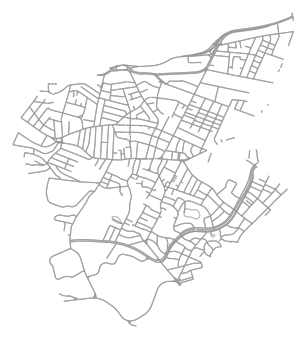

(<Figure size 376.642x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fed3870a590>)

In [31]:
ox.plot.plot_graph(brighton_sidewalk_G)

import osmnx as ox
import networkx as nx

brighton_sidewalks['grade'] = 0

# given a segment, find the perpendiculars from each end
# thanks Georgy!
# https://stackoverflow.com/a/57072678
from shapely.ops import unary_union
PERP_WIDTH = 1.3

def get_perps(street_seg):
    left_side = street_seg.parallel_offset(PERP_WIDTH, 'left')
    right_side = street_seg.parallel_offset(PERP_WIDTH, 'right')
    # keep them on the same side so you know that the two first coordinates are paired, etc.
    perp0 = LineString([left_side.boundary[1], right_side.boundary[0]])
    perp1 = LineString([left_side.boundary[0], right_side.boundary[1]])
    return perp0, perp1

def get_perp_points(street_seg):
    perp0, perp1 = get_perps(street_seg)
    left_points = (perp0.coords[0], perp1.coords[0])
    right_points = (perp0.coords[1], perp1.coords[1])
    return left_points, right_points

def nearest_node(lat, lon, graph):
    return ox.get_nearest_node(graph, (lat, lon), method='euclidean')  
    
# I've finally written an entirely impure function, lol
def assign_route(row):
    
    street_seg = row['geometry']
    grade = row['angle_deg']
    left_points, right_points = get_perp_points(street_seg)
    
    left_nodes = [nearest_node(lat, lon, brighton_sidewalk_G) for lat, lon in left_points]
    right_nodes = [nearest_node(lat, lon, brighton_sidewalk_G) for lat, lon in right_points]
    
    left_route = nx.shortest_path(brighton_sidewalk_G, left_nodes[0], left_nodes[1])
    right_route = nx.shortest_path(brighton_sidewalk_G, right_nodes[0], right_nodes[1])
    
    left_route_pairs = zip(left_route[:-1], left_route[1:])
    right_route_pairs = zip(right_route[:-1], right_route[1:])
    #for (u,v) in left_route_pairs:
    #    brighton_sidewalks.loc[ ((brighton_sidewalks['u'] == u) & (brighton_sidewalks['v'] == v)) | 
    #                            ((brighton_sidewalks['u'] == v) & (brighton_sidewalks['v'] == u)), 'grade' ] = grade
    #for (u,v) in right_route_pairs:
    #    brighton_sidewalks.loc[ ((brighton_sidewalks['u'] == u) & (brighton_sidewalks['v'] == v)) | 
    #                            ((brighton_sidewalks['u'] == v) & (brighton_sidewalks['v'] == u)), 'grade'] = grade
    return (left_route_pairs, right_route_pairs)


In [32]:
# let's try get_nearest_edge instead of get_nearest_node
# TODO: combine the two approaches, use offsets from the endpoints and then get_nearest_edge
PERP_WIDTH = 2
def get_perps(street_seg, width=PERP_WIDTH):
    left_side = street_seg.parallel_offset(width, 'left')
    right_side = street_seg.parallel_offset(width, 'right')
    return left_side, right_side

def midpoint(linestring):
    p0, p1 = linestring.coords[0], linestring.coords[-1]
    x0, y0 = p0
    x1, y1 = p1
    return ((x1 + x0)/2, (y1 + y0)/2)

def get_perp_midpoints(street_seg):
    perp0, perp1 = get_perps(street_seg)
    midpoint0 = midpoint(perp0)
    midpoint1 = midpoint(perp1)
    return [midpoint0, midpoint1]

def get_relevant_edges(pt_list):
    # would be nice to do this as batch but whatever
    x_coords = [pt[0] for pt in pt_list]
    y_coords = [pt[1] for pt in pt_list]
    return ox.distance.get_nearest_edges(brighton_sidewalk_G, x_coords, y_coords, method='kdtree', dist=0.5)



In [33]:
# rather than assign 'nearest_sidewalk' to each street, let's just gather all the coordinates we need to eliminate:
bad_midpoints = brighton_streets_long[(brighton_streets_long['angle_deg'] > 4) 
                           | (brighton_streets_long['angle_deg'] < -4)].geometry.map(get_perp_midpoints)
bad_midpoints = np.concatenate(bad_midpoints.values)
bad_edges = get_relevant_edges(bad_midpoints)
bad_edges = [(u,v) for u,v, _ in bad_edges.tolist()] + [(v,u) for u, v, _ in bad_edges.tolist()]

In principle we don't need to check for both (u,v) and (v,u), double check with length

`len(bad_edges) == 25388`

In [34]:
print(len(brighton_sidewalk_G.edges))
brighton_sidewalk_G.remove_edges_from(bad_edges)
len(brighton_sidewalk_G.edges)


56597


48067

`(56597 - 48067)/56597 == 0.1507`
Checks out -- about 15% of sidewalks not usable

In [50]:
len(brighton_sidewalk_G.edges)


48067

In [48]:
brighton_sidewalk_pts, brighton_sidewalk_edges = ox.graph_to_gdfs(brighton_sidewalk_G)
brighton_sidewalk_pts.crs = "EPSG:26919"
brighton_sidewalk_edges.crs = "EPSG:26919"
brighton_sidewalk_pts = brighton_sidewalk_pts.to_crs("EPSG:4326")
brighton_sidewalk_edges = brighton_sidewalk_edges.to_crs("EPSG:4326")
brighton_sidewalk_G = ox.graph_from_gdfs(brighton_sidewalk_pts, brighton_sidewalk_edges)

In [55]:
import networkx as nx
nx.number_connected_components(brighton_sidewalk_G.to_undirected())

8661

In [73]:
ccs =  [brighton_sidewalk_G.subgraph(c).copy() for c in nx.connected_components(brighton_sidewalk_G.to_undirected())]

In [79]:
def length_graph(G):
    return sum([edge[2] for edge in G.edges(data='length')])

In [80]:
length_dict = {cc: length_graph(cc) for cc in ccs}

In [95]:
pd.Series(list(length_dict.values())).describe(percentiles=[.9])


count    8661.000000
mean       19.215956
std        20.868596
min         0.000000
50%        16.103718
90%        42.855939
max       193.266277
dtype: float64

Declare a good segment to be 50ft/16m. so that we can delete at ~50%.

In [96]:
ccs_long = [cc for cc in ccs if length_graph(cc) > 16 ]

In [97]:
len(ccs_long)

4571

In [108]:
temp = nx.MultiGraph()
for cc in ccs_long:
    temp.add_nodes_from(cc.nodes(data=True))
    temp.add_edges_from(cc.edges(data=True))

In [110]:
temp.graph['crs'] = "EPSG:4326"

(None, 193.26627663298476)

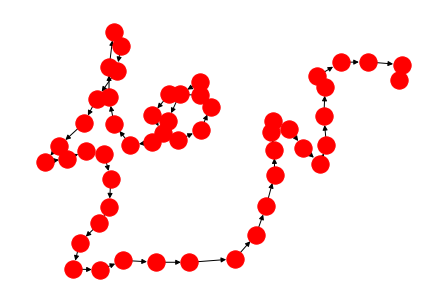

In [124]:
big = sorted(ccs_long, key=length_graph, reverse=True)[0]
nx.draw(big), length_graph(big)

/home/adam/.local/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:563: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/adam/.local/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:660: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


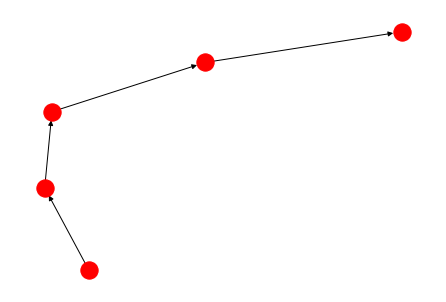